In [1]:
# データセット作成

!pip install scipy

window_size = 1024
window_num_per_clip = 40
clip_size = window_size * window_num_per_clip

from scipy.io.wavfile import read
import glob
import os
import numpy as np

def standardization(x):
    ret = np.log(x + 1) / np.log(np.finfo(np.float32).max)
    if (np.sum(ret) == 0):
        return ret
    else:
        return ret / np.sum(ret)

if os.path.isfile("../data/arrays/clips.npy"):
    print("clips.npy exists.")
    clips = np.load("../data/arrays/clips.npy")
else:
    files = glob.glob("../data/wav44100/*")
    #files = ["../data/wav44100/3DEmbodimentFromLines.wav"]
    raw_data_list = [read(file)[1] for file in files]

    clips = np.zeros((0, clip_size), dtype=np.int16)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save("../data/arrays/clips", clips)
    
print("clips.shape: " + str(clips.shape))
    
if os.path.isfile("../data/arrays/fft_log_normalized.npy"):
    print("fft_log_normalized.npy exists.")
    fft = np.load("../data/arrays/fft_log_normalized.npy")
else:
    fft = np.zeros((0, window_num_per_clip, window_size))
    num = 0
    for clip in clips:
        print("fft progress: clip " + str(num))
        
        fft_tmp = np.zeros((0, window_size))
        tmp = [clip[i:i + window_size] for i in range(0, len(clip) - window_size + 1, window_size)]
        for tmp2 in tmp:
            spectrum = np.abs(np.fft.fft(tmp2))
            spectrum = standardization(spectrum)
            fft_tmp = np.vstack((fft_tmp, spectrum))
        fft = np.vstack((fft, fft_tmp.reshape(1, window_num_per_clip, window_size)))
        num += 1

    np.save("../data/arrays/fft_log_normalized", fft)

print(fft.shape)
print(type(fft[0][0][0]))
print(clips.shape)

print(fft[0][0])

     |████████████████████████████████| 34.5 MB 16.9 MB/s eta 0:00:01   |█▋                              | 1.8 MB 4.5 MB/s eta 0:00:08
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
clips.npy exists.
clips.shape: (28576, 40960)
fft_log_normalized.npy exists.
(28576, 40, 1024)
<class 'numpy.float64'>
(28576, 40960)
[0.0017106  0.00181047 0.00211305 ... 0.00209956 0.00211305 0.00181047]


In [2]:
# 学習データとテストデータに分ける

train_data_rate = 0.8

p = np.random.permutation(len(fft))
fft = fft[p]
clips = clips[p]

x_train = fft[:int(fft.shape[0] * train_data_rate), :, :].reshape(int(fft.shape[0] * train_data_rate), window_num_per_clip, window_size, 1)
x_test = fft[int(fft.shape[0] * train_data_rate):-1, :, :].reshape(fft.shape[0] - int(fft.shape[0] * train_data_rate) - 1, window_num_per_clip, window_size, 1)
y_train = fft[1:int(fft.shape[0] * train_data_rate) + 1, 0, :]
y_test = fft[int(fft.shape[0] * train_data_rate) + 1:, 0, :]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(np.max(x_train[0]))

(22860, 40, 1024, 1)
(5715, 40, 1024, 1)
(22860, 1024)
(5715, 1024)
0.002196256916713653


In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input
from keras.optimizers import Adam

learning_rate = 0.0001
 
model = keras.models.Sequential()
model.add(Conv2D(3, (3, 1), activation='relu', input_shape=(window_num_per_clip, window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 1024, 3)       12        
                                                                 
 dropout (Dropout)           (None, 38, 1024, 3)       0         
                                                                 
 flatten (Flatten)           (None, 116736)            0         
                                                                 
 dense (Dense)               (None, 512)               59769344  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [5]:
# 学習

history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=1000,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/fft_batch256_e1000")

Epoch 1/1000
90/90 [==============================] - 52s 577ms/step - loss: 6.9008 - accuracy: 0.0112 - val_loss: 6.8892 - val_accuracy: 0.0000e+00
Epoch 2/1000
90/90 [==============================] - 53s 593ms/step - loss: 6.8954 - accuracy: 0.0416 - val_loss: 6.8891 - val_accuracy: 0.0000e+00
Epoch 3/1000
90/90 [==============================] - 52s 574ms/step - loss: 6.8951 - accuracy: 0.0517 - val_loss: 6.8892 - val_accuracy: 0.0000e+00
Epoch 4/1000
90/90 [==============================] - 57s 636ms/step - loss: 6.8950 - accuracy: 0.0625 - val_loss: 6.8891 - val_accuracy: 0.1507
Epoch 5/1000
90/90 [==============================] - 55s 613ms/step - loss: 6.8949 - accuracy: 0.0621 - val_loss: 6.8891 - val_accuracy: 0.0035
Epoch 6/1000
90/90 [==============================] - 53s 592ms/step - loss: 6.8949 - accuracy: 0.0699 - val_loss: 6.8891 - val_accuracy: 0.0000e+00
Epoch 7/1000
90/90 [==============================] - 52s 573ms/step - loss: 6.8949 - accuracy: 0.0655 - val_loss:

Epoch 56/1000
90/90 [==============================] - 50s 561ms/step - loss: 27.8945 - accuracy: 0.0044 - val_loss: 16.3864 - val_accuracy: 0.0000e+00
Epoch 57/1000
90/90 [==============================] - 51s 565ms/step - loss: 13.9135 - accuracy: 0.0067 - val_loss: 12.1008 - val_accuracy: 0.0000e+00
Epoch 58/1000
90/90 [==============================] - 51s 570ms/step - loss: 11.1064 - accuracy: 0.0120 - val_loss: 10.2058 - val_accuracy: 0.0000e+00
Epoch 59/1000
90/90 [==============================] - 51s 563ms/step - loss: 9.6416 - accuracy: 0.0168 - val_loss: 9.0850 - val_accuracy: 0.0000e+00
Epoch 60/1000
90/90 [==============================] - 51s 562ms/step - loss: 8.7062 - accuracy: 0.0228 - val_loss: 8.3529 - val_accuracy: 0.1055
Epoch 61/1000
90/90 [==============================] - 50s 557ms/step - loss: 8.1203 - accuracy: 0.0304 - val_loss: 7.8743 - val_accuracy: 0.0000e+00
Epoch 62/1000
90/90 [==============================] - 51s 563ms/step - loss: 7.7328 - accuracy: 0

90/90 [==============================] - 51s 565ms/step - loss: 97.9580 - accuracy: 0.0020 - val_loss: 53.2302 - val_accuracy: 0.0000e+00
Epoch 111/1000
90/90 [==============================] - 51s 563ms/step - loss: 31.0950 - accuracy: 0.0023 - val_loss: 20.0472 - val_accuracy: 0.0000e+00
Epoch 112/1000
90/90 [==============================] - 51s 566ms/step - loss: 16.9309 - accuracy: 0.0082 - val_loss: 14.3562 - val_accuracy: 0.0192
Epoch 113/1000
90/90 [==============================] - 50s 559ms/step - loss: 12.9107 - accuracy: 0.0158 - val_loss: 11.6424 - val_accuracy: 0.0000e+00
Epoch 114/1000
90/90 [==============================] - 51s 567ms/step - loss: 10.8354 - accuracy: 0.0179 - val_loss: 10.0435 - val_accuracy: 0.0000e+00
Epoch 115/1000
90/90 [==============================] - 51s 571ms/step - loss: 9.4502 - accuracy: 0.0184 - val_loss: 8.8746 - val_accuracy: 0.0000e+00
Epoch 116/1000
90/90 [==============================] - 51s 572ms/step - loss: 8.5303 - accuracy: 0.025

90/90 [==============================] - 51s 569ms/step - loss: 86.6946 - accuracy: 0.0037 - val_loss: 171.7272 - val_accuracy: 0.0000e+00
Epoch 165/1000
90/90 [==============================] - 51s 565ms/step - loss: 157.0064 - accuracy: 0.0017 - val_loss: 111.3041 - val_accuracy: 0.0000e+00
Epoch 166/1000
90/90 [==============================] - 51s 568ms/step - loss: 65.8525 - accuracy: 0.0015 - val_loss: 31.9995 - val_accuracy: 0.0000e+00
Epoch 167/1000
90/90 [==============================] - 50s 561ms/step - loss: 23.9498 - accuracy: 0.0031 - val_loss: 19.0848 - val_accuracy: 0.0000e+00
Epoch 168/1000
90/90 [==============================] - 51s 564ms/step - loss: 16.4772 - accuracy: 0.0065 - val_loss: 14.2367 - val_accuracy: 0.0777
Epoch 169/1000
90/90 [==============================] - 51s 570ms/step - loss: 12.8791 - accuracy: 0.0133 - val_loss: 11.6264 - val_accuracy: 0.1507
Epoch 170/1000
90/90 [==============================] - 50s 558ms/step - loss: 10.8145 - accuracy: 0.0

90/90 [==============================] - 53s 595ms/step - loss: 6.9087 - accuracy: 0.0370 - val_loss: 6.8905 - val_accuracy: 0.1507
Epoch 219/1000
90/90 [==============================] - 52s 580ms/step - loss: 6.9066 - accuracy: 0.0371 - val_loss: 6.8908 - val_accuracy: 0.0000e+00
Epoch 220/1000
90/90 [==============================] - 52s 578ms/step - loss: 45.6724 - accuracy: 0.0159 - val_loss: 152.2488 - val_accuracy: 0.0000e+00
Epoch 221/1000
90/90 [==============================] - 53s 589ms/step - loss: 166.0621 - accuracy: 0.0016 - val_loss: 136.7489 - val_accuracy: 0.0000e+00
Epoch 222/1000
90/90 [==============================] - 52s 580ms/step - loss: 88.6545 - accuracy: 0.0032 - val_loss: 46.9452 - val_accuracy: 0.0000e+00
Epoch 223/1000
90/90 [==============================] - 51s 572ms/step - loss: 30.0184 - accuracy: 0.0038 - val_loss: 20.9658 - val_accuracy: 0.0000e+00
Epoch 224/1000
90/90 [==============================] - 52s 578ms/step - loss: 18.3151 - accuracy: 0.0

90/90 [==============================] - 50s 557ms/step - loss: 6.8960 - accuracy: 0.0359 - val_loss: 6.8892 - val_accuracy: 0.0000e+00
Epoch 273/1000
90/90 [==============================] - 51s 563ms/step - loss: 6.9130 - accuracy: 0.0346 - val_loss: 7.0161 - val_accuracy: 0.0000e+00
Epoch 274/1000
90/90 [==============================] - 51s 568ms/step - loss: 28.1485 - accuracy: 0.0077 - val_loss: 95.5572 - val_accuracy: 0.0000e+00
Epoch 275/1000
90/90 [==============================] - 50s 561ms/step - loss: 140.4584 - accuracy: 0.0028 - val_loss: 142.7183 - val_accuracy: 0.0000e+00
Epoch 276/1000
90/90 [==============================] - 51s 562ms/step - loss: 104.2157 - accuracy: 0.0011 - val_loss: 61.4239 - val_accuracy: 0.0000e+00
Epoch 277/1000
90/90 [==============================] - 51s 568ms/step - loss: 37.5557 - accuracy: 2.6247e-04 - val_loss: 22.4841 - val_accuracy: 0.0000e+00
Epoch 278/1000
90/90 [==============================] - 51s 571ms/step - loss: 18.3219 - accur

90/90 [==============================] - 51s 570ms/step - loss: 6.9082 - accuracy: 0.0340 - val_loss: 6.8914 - val_accuracy: 0.0117
Epoch 327/1000
90/90 [==============================] - 51s 568ms/step - loss: 6.8996 - accuracy: 0.0343 - val_loss: 6.8897 - val_accuracy: 0.1055
Epoch 328/1000
90/90 [==============================] - 51s 564ms/step - loss: 6.8970 - accuracy: 0.0367 - val_loss: 6.8895 - val_accuracy: 0.0000e+00
Epoch 329/1000
90/90 [==============================] - 51s 568ms/step - loss: 6.8959 - accuracy: 0.0350 - val_loss: 6.8893 - val_accuracy: 0.0000e+00
Epoch 330/1000
90/90 [==============================] - 51s 565ms/step - loss: 6.8954 - accuracy: 0.0533 - val_loss: 6.8895 - val_accuracy: 0.0856
Epoch 331/1000
90/90 [==============================] - 52s 573ms/step - loss: 6.9640 - accuracy: 0.0252 - val_loss: 12.2193 - val_accuracy: 0.0000e+00
Epoch 332/1000
90/90 [==============================] - 51s 566ms/step - loss: 122.1106 - accuracy: 0.0013 - val_loss: 2

90/90 [==============================] - 51s 570ms/step - loss: 7.6178 - accuracy: 0.0277 - val_loss: 7.4075 - val_accuracy: 0.1055
Epoch 381/1000
90/90 [==============================] - 52s 574ms/step - loss: 7.2936 - accuracy: 0.0282 - val_loss: 7.1379 - val_accuracy: 0.0000e+00
Epoch 382/1000
90/90 [==============================] - 51s 563ms/step - loss: 7.0639 - accuracy: 0.0378 - val_loss: 6.9620 - val_accuracy: 0.0000e+00
Epoch 383/1000
90/90 [==============================] - 51s 569ms/step - loss: 6.9556 - accuracy: 0.0319 - val_loss: 6.9021 - val_accuracy: 0.1055
Epoch 384/1000
90/90 [==============================] - 51s 572ms/step - loss: 6.9178 - accuracy: 0.0314 - val_loss: 6.8917 - val_accuracy: 0.0000e+00
Epoch 385/1000
90/90 [==============================] - 51s 563ms/step - loss: 6.9137 - accuracy: 0.0315 - val_loss: 6.8918 - val_accuracy: 0.0000e+00
Epoch 386/1000
90/90 [==============================] - 51s 567ms/step - loss: 6.9110 - accuracy: 0.0360 - val_loss: 

Epoch 435/1000
90/90 [==============================] - 51s 570ms/step - loss: 9.5525 - accuracy: 0.0157 - val_loss: 8.9986 - val_accuracy: 0.1507
Epoch 436/1000
90/90 [==============================] - 51s 568ms/step - loss: 8.6211 - accuracy: 0.0206 - val_loss: 8.2977 - val_accuracy: 0.1507
Epoch 437/1000
90/90 [==============================] - 51s 564ms/step - loss: 8.1209 - accuracy: 0.0356 - val_loss: 7.8920 - val_accuracy: 0.0000e+00
Epoch 438/1000
90/90 [==============================] - 51s 569ms/step - loss: 7.7392 - accuracy: 0.0385 - val_loss: 7.5509 - val_accuracy: 0.1507
Epoch 439/1000
90/90 [==============================] - 52s 572ms/step - loss: 7.4416 - accuracy: 0.0510 - val_loss: 7.3370 - val_accuracy: 0.0000e+00
Epoch 440/1000
90/90 [==============================] - 51s 562ms/step - loss: 7.2730 - accuracy: 0.0644 - val_loss: 7.1787 - val_accuracy: 0.0000e+00
Epoch 441/1000
90/90 [==============================] - 51s 563ms/step - loss: 7.1151 - accuracy: 0.0703 -

90/90 [==============================] - 51s 563ms/step - loss: 6.9015 - accuracy: 0.0349 - val_loss: 7.1227 - val_accuracy: 0.0096
Epoch 490/1000
90/90 [==============================] - 51s 568ms/step - loss: 63.5045 - accuracy: 0.0036 - val_loss: 153.8974 - val_accuracy: 0.0000e+00
Epoch 491/1000
90/90 [==============================] - 52s 573ms/step - loss: 144.8282 - accuracy: 0.0024 - val_loss: 103.9702 - val_accuracy: 0.0000e+00
Epoch 492/1000
90/90 [==============================] - 52s 577ms/step - loss: 65.9557 - accuracy: 0.0021 - val_loss: 35.1244 - val_accuracy: 0.0000e+00
Epoch 493/1000
90/90 [==============================] - 52s 572ms/step - loss: 24.9318 - accuracy: 0.0037 - val_loss: 18.9202 - val_accuracy: 0.0000e+00
Epoch 494/1000
90/90 [==============================] - 51s 563ms/step - loss: 16.4648 - accuracy: 0.0124 - val_loss: 14.4766 - val_accuracy: 0.0000e+00
Epoch 495/1000
90/90 [==============================] - 51s 563ms/step - loss: 13.3631 - accuracy: 0

90/90 [==============================] - 51s 562ms/step - loss: 6.9071 - accuracy: 0.0284 - val_loss: 6.8917 - val_accuracy: 0.0000e+00
Epoch 544/1000
90/90 [==============================] - 51s 564ms/step - loss: 6.9040 - accuracy: 0.0346 - val_loss: 6.8904 - val_accuracy: 0.0000e+00
Epoch 545/1000
90/90 [==============================] - 51s 564ms/step - loss: 6.9020 - accuracy: 0.0316 - val_loss: 6.8902 - val_accuracy: 0.1507
Epoch 546/1000
90/90 [==============================] - 51s 564ms/step - loss: 6.9004 - accuracy: 0.0237 - val_loss: 6.8930 - val_accuracy: 0.1440
Epoch 547/1000
90/90 [==============================] - 51s 566ms/step - loss: 7.3895 - accuracy: 0.0251 - val_loss: 8.0550 - val_accuracy: 0.1507
Epoch 548/1000
90/90 [==============================] - 51s 568ms/step - loss: 52.8602 - accuracy: 0.0052 - val_loss: 104.3097 - val_accuracy: 0.0000e+00
Epoch 549/1000
90/90 [==============================] - 50s 562ms/step - loss: 95.2418 - accuracy: 0.0012 - val_loss: 

90/90 [==============================] - 50s 554ms/step - loss: 7.4521 - accuracy: 0.0462 - val_loss: 7.3487 - val_accuracy: 0.1507
Epoch 598/1000
90/90 [==============================] - 51s 568ms/step - loss: 7.2837 - accuracy: 0.0516 - val_loss: 7.2011 - val_accuracy: 0.1440
Epoch 599/1000
90/90 [==============================] - 51s 565ms/step - loss: 7.1691 - accuracy: 0.0517 - val_loss: 7.1121 - val_accuracy: 0.0000e+00
Epoch 600/1000
90/90 [==============================] - 51s 563ms/step - loss: 7.0745 - accuracy: 0.0405 - val_loss: 7.0133 - val_accuracy: 0.0000e+00
Epoch 601/1000
90/90 [==============================] - 50s 557ms/step - loss: 6.9728 - accuracy: 0.0435 - val_loss: 6.9172 - val_accuracy: 0.0000e+00
Epoch 602/1000
90/90 [==============================] - 50s 560ms/step - loss: 6.9082 - accuracy: 0.0409 - val_loss: 6.8914 - val_accuracy: 0.0000e+00
Epoch 603/1000
90/90 [==============================] - 51s 568ms/step - loss: 6.9022 - accuracy: 0.0369 - val_loss: 

90/90 [==============================] - 51s 565ms/step - loss: 7.0053 - accuracy: 0.0351 - val_loss: 6.9502 - val_accuracy: 0.0000e+00
Epoch 652/1000
90/90 [==============================] - 50s 559ms/step - loss: 6.9432 - accuracy: 0.0307 - val_loss: 6.9126 - val_accuracy: 0.0000e+00
Epoch 653/1000
90/90 [==============================] - 50s 560ms/step - loss: 6.9092 - accuracy: 0.0274 - val_loss: 6.8904 - val_accuracy: 0.0000e+00
Epoch 654/1000
90/90 [==============================] - 51s 565ms/step - loss: 6.9012 - accuracy: 0.0292 - val_loss: 6.8898 - val_accuracy: 0.0000e+00
Epoch 655/1000
90/90 [==============================] - 51s 565ms/step - loss: 6.8997 - accuracy: 0.0250 - val_loss: 6.8897 - val_accuracy: 0.0000e+00
Epoch 656/1000
90/90 [==============================] - 51s 562ms/step - loss: 6.8987 - accuracy: 0.0301 - val_loss: 6.8897 - val_accuracy: 0.0520
Epoch 657/1000
90/90 [==============================] - 51s 562ms/step - loss: 6.9362 - accuracy: 0.0222 - val_lo

Epoch 706/1000
90/90 [==============================] - 50s 557ms/step - loss: 7.2091 - accuracy: 0.0518 - val_loss: 7.1004 - val_accuracy: 0.1507
Epoch 707/1000
90/90 [==============================] - 51s 567ms/step - loss: 7.0377 - accuracy: 0.0534 - val_loss: 6.9770 - val_accuracy: 0.0777
Epoch 708/1000
90/90 [==============================] - 51s 565ms/step - loss: 6.9648 - accuracy: 0.0526 - val_loss: 6.9385 - val_accuracy: 0.0000e+00
Epoch 709/1000
90/90 [==============================] - 51s 563ms/step - loss: 6.9293 - accuracy: 0.0616 - val_loss: 6.9041 - val_accuracy: 0.1507
Epoch 710/1000
90/90 [==============================] - 51s 570ms/step - loss: 6.8997 - accuracy: 0.0722 - val_loss: 6.8896 - val_accuracy: 0.0777
Epoch 711/1000
90/90 [==============================] - 51s 572ms/step - loss: 6.8958 - accuracy: 0.0660 - val_loss: 6.8893 - val_accuracy: 0.1507
Epoch 712/1000
90/90 [==============================] - 51s 561ms/step - loss: 6.8953 - accuracy: 0.0630 - val_los

90/90 [==============================] - 51s 565ms/step - loss: 8.9366 - accuracy: 0.0283 - val_loss: 8.5416 - val_accuracy: 0.1055
Epoch 761/1000
90/90 [==============================] - 50s 560ms/step - loss: 8.3011 - accuracy: 0.0315 - val_loss: 8.0826 - val_accuracy: 0.0000e+00
Epoch 762/1000
90/90 [==============================] - 51s 571ms/step - loss: 7.9350 - accuracy: 0.0355 - val_loss: 7.7616 - val_accuracy: 0.1055
Epoch 763/1000
90/90 [==============================] - 51s 562ms/step - loss: 7.6297 - accuracy: 0.0374 - val_loss: 7.4797 - val_accuracy: 0.0000e+00
Epoch 764/1000
90/90 [==============================] - 51s 562ms/step - loss: 7.3535 - accuracy: 0.0367 - val_loss: 7.2341 - val_accuracy: 0.0000e+00
Epoch 765/1000
90/90 [==============================] - 51s 563ms/step - loss: 7.1653 - accuracy: 0.0438 - val_loss: 7.0774 - val_accuracy: 0.1440
Epoch 766/1000
90/90 [==============================] - 51s 563ms/step - loss: 7.0299 - accuracy: 0.0496 - val_loss: 6.97

90/90 [==============================] - 50s 559ms/step - loss: 9.7009 - accuracy: 0.0143 - val_loss: 9.1333 - val_accuracy: 0.1440
Epoch 816/1000
90/90 [==============================] - 50s 559ms/step - loss: 8.7514 - accuracy: 0.0170 - val_loss: 8.3414 - val_accuracy: 0.1507
Epoch 817/1000
90/90 [==============================] - 51s 568ms/step - loss: 8.0551 - accuracy: 0.0253 - val_loss: 7.7676 - val_accuracy: 0.1507
Epoch 818/1000
90/90 [==============================] - 50s 555ms/step - loss: 7.5886 - accuracy: 0.0287 - val_loss: 7.3914 - val_accuracy: 0.0000e+00
Epoch 819/1000
90/90 [==============================] - 50s 558ms/step - loss: 7.2896 - accuracy: 0.0321 - val_loss: 7.1712 - val_accuracy: 0.1507
Epoch 820/1000
90/90 [==============================] - 50s 557ms/step - loss: 7.0965 - accuracy: 0.0369 - val_loss: 7.0022 - val_accuracy: 0.1507
Epoch 821/1000
90/90 [==============================] - 51s 571ms/step - loss: 6.9679 - accuracy: 0.0339 - val_loss: 6.9108 - val

Epoch 870/1000
90/90 [==============================] - 51s 563ms/step - loss: 8.2877 - accuracy: 0.0153 - val_loss: 7.8534 - val_accuracy: 0.0000e+00
Epoch 871/1000
90/90 [==============================] - 50s 560ms/step - loss: 7.5693 - accuracy: 0.0151 - val_loss: 7.3016 - val_accuracy: 0.1507
Epoch 872/1000
90/90 [==============================] - 51s 564ms/step - loss: 7.1916 - accuracy: 0.0213 - val_loss: 7.0825 - val_accuracy: 0.0000e+00
Epoch 873/1000
90/90 [==============================] - 51s 561ms/step - loss: 7.0336 - accuracy: 0.0208 - val_loss: 6.9529 - val_accuracy: 0.0000e+00
Epoch 874/1000
90/90 [==============================] - 50s 559ms/step - loss: 6.9440 - accuracy: 0.0265 - val_loss: 6.9063 - val_accuracy: 0.1440
Epoch 875/1000
90/90 [==============================] - 50s 560ms/step - loss: 6.9129 - accuracy: 0.0276 - val_loss: 6.8928 - val_accuracy: 0.1507
Epoch 876/1000
90/90 [==============================] - 50s 555ms/step - loss: 6.9082 - accuracy: 0.0347 -

90/90 [==============================] - 51s 564ms/step - loss: 6.8967 - accuracy: 0.0333 - val_loss: 6.8893 - val_accuracy: 0.0000e+00
Epoch 925/1000
90/90 [==============================] - 50s 556ms/step - loss: 6.8962 - accuracy: 0.0296 - val_loss: 6.8893 - val_accuracy: 0.0777
Epoch 926/1000
90/90 [==============================] - 51s 562ms/step - loss: 6.8959 - accuracy: 0.0328 - val_loss: 6.8901 - val_accuracy: 0.0000e+00
Epoch 927/1000
90/90 [==============================] - 51s 562ms/step - loss: 6.9368 - accuracy: 0.0241 - val_loss: 6.9691 - val_accuracy: 0.0000e+00
Epoch 928/1000
90/90 [==============================] - 51s 569ms/step - loss: 31.5605 - accuracy: 0.0038 - val_loss: 69.4995 - val_accuracy: 0.0000e+00
Epoch 929/1000
90/90 [==============================] - 51s 567ms/step - loss: 42.8243 - accuracy: 0.0012 - val_loss: 19.0124 - val_accuracy: 0.0000e+00
Epoch 930/1000
90/90 [==============================] - 51s 562ms/step - loss: 13.2002 - accuracy: 0.0035 - v

Epoch 979/1000
90/90 [==============================] - 51s 562ms/step - loss: 11.9935 - accuracy: 0.0032 - val_loss: 9.0725 - val_accuracy: 0.0000e+00
Epoch 980/1000
90/90 [==============================] - 50s 561ms/step - loss: 8.3745 - accuracy: 0.0094 - val_loss: 7.8182 - val_accuracy: 0.0000e+00
Epoch 981/1000
90/90 [==============================] - 51s 561ms/step - loss: 7.5361 - accuracy: 0.0163 - val_loss: 7.2785 - val_accuracy: 0.0000e+00
Epoch 982/1000
90/90 [==============================] - 50s 561ms/step - loss: 7.1734 - accuracy: 0.0157 - val_loss: 7.0590 - val_accuracy: 0.0000e+00
Epoch 983/1000
90/90 [==============================] - 51s 564ms/step - loss: 7.0019 - accuracy: 0.0171 - val_loss: 6.9362 - val_accuracy: 0.1507
Epoch 984/1000
90/90 [==============================] - 50s 557ms/step - loss: 6.9227 - accuracy: 0.0170 - val_loss: 6.8965 - val_accuracy: 0.0000e+00
Epoch 985/1000
90/90 [==============================] - 51s 563ms/step - loss: 6.8998 - accuracy:

INFO:tensorflow:Assets written to: ../data/models/fft_batch256_e1000/assets


INFO:tensorflow:Assets written to: ../data/models/fft_batch256_e1000/assets


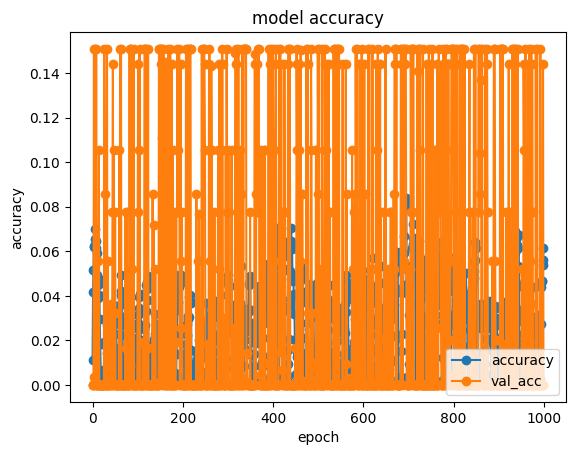

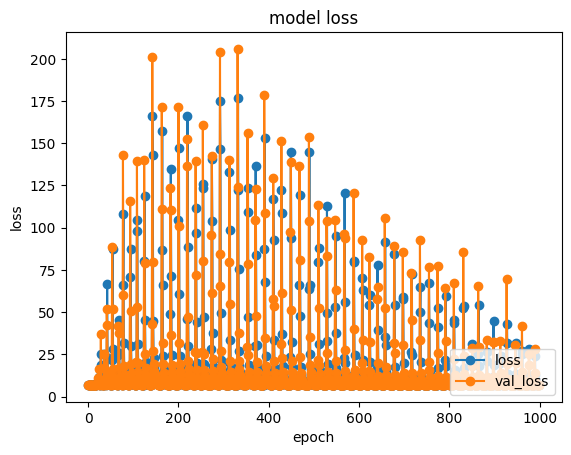

In [6]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [7]:
# 楽曲の出力

!pip install scikit-learn

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.io import wavfile
from keras.models import load_model

model = load_model("../data/models/fft_batch256_e1000")

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out_1.wav", 44100, out)

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out_2.wav", 44100, out)

first_index = np.random.randint(0, len(x_test))
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out_3.wav", 44100, out)

     |████████████████████████████████| 9.8 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 10.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
1/1 [==============================] - 0s 78ms/step
461
1/1 [==============================] - 0s 32ms/step
461
1/1 [==============================] - 0s 30ms/step
461
1/1 [==============================] - 0s 31ms/step
461
1/1 [==============================] - 0s 31ms/step
461
1/1 [==============================] - 0s 29ms/step
461
1/1 [==============================] - 0s 32ms/step
461
1/1 [==============================] - 0s 32ms/step
461
1/1 [==============================] - 0s 29ms/step
461
1/1 [==============================] - 0s 29ms/step
461
1/1 [==============================] - 0s 29ms/step
461
1/1 [==============================] - 0s 29ms/step
461
1/1 [==============================] - 0s 29ms/step
461
1/1 [==============================] - 0